In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size=(len(itos))
vocab_size

27

In [21]:
#buidling the dataset
block_size = 3
def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] +[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])



In [42]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator = g)
W1 = torch.randn((n_embed*block_size,n_hidden), generator = g) * (5/3)/((n_embed*block_size)**0.5)
#b1 = torch.randn(n_hidden, generator = g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

bnmean_running = torch.zeros([1,n_hidden])
bnstd_running = torch.ones([1,n_hidden])
bngain = torch.ones([1,n_hidden])
bnbias = torch.zeros([1,n_hidden])

parameters = [C,W1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


12097


In [8]:
#hpreact.shape

In [9]:
#hpreact.mean(0,keepdim=True).shape
#hpreact.std(0,keepdim=True).shape

In [43]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    #making a batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+b1
    bnmeani =hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias #batch normalisation

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits,Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #stats
    if i %1000 ==0:
        print(f'{loss.item():4f}')
    lossi.append(loss.log10().item())










3.285633


2.534202
2.434208
2.224304
2.501032
2.159402
1.943409
2.365490
2.276790
2.339267
2.134008
2.270283
2.282225
2.177814
2.070806
1.884469
1.864698
2.044937
2.288980
2.213271


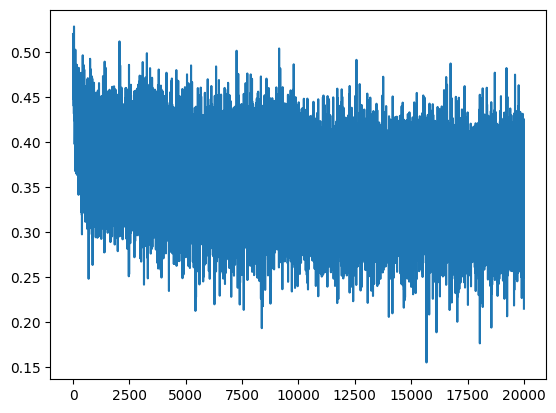

In [11]:
plt.plot(lossi)

In [44]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)
    


In [34]:
bnmean_running

tensor([[-1.1326, -0.1227, -1.0549,  0.7757,  0.7918,  0.5088,  1.3742, -0.4567,
          0.1998,  0.8172, -1.1415, -1.4975, -0.1176, -0.3421, -0.1159,  0.4819,
          0.6198, -1.4515, -0.5686,  0.7380,  0.4170, -0.5176, -0.1156,  0.5165,
          0.4789,  0.5526,  0.7070, -0.1233, -0.0542,  0.9158, -0.4724, -0.8707,
          0.3107,  0.3120, -0.2991, -0.8318, -0.9048, -0.4847, -0.1770,  0.4201,
         -0.1643, -0.9549, -0.6618,  0.0951,  0.5291,  0.0780,  0.4049, -0.5474,
          0.8299,  1.2556,  0.5840,  0.0401,  1.2977,  1.1306,  0.9134, -1.1833,
         -0.1453,  0.5307,  1.3104, -0.7698, -0.4660,  0.3657,  0.3197,  0.0184,
          1.2299,  0.6237,  0.2116,  0.7142, -0.4248, -0.2065,  0.0414,  0.7015,
          0.7130, -1.0454, -1.4901, -0.0449,  0.9197,  0.1008,  0.2687,  0.3429,
          0.5710,  1.1984,  0.8799,  0.5664,  0.3933, -0.3856, -1.0471,  0.3354,
          0.9309, -0.2407, -0.4389,  0.7322, -0.1203, -0.3660, -0.2527, -0.2899,
         -0.6787, -0.1893,  

In [33]:
bnmean

tensor([[-1.1427, -0.1256, -1.0501,  0.7802,  0.7971,  0.5101,  1.3732, -0.4507,
          0.1852,  0.8186, -1.1431, -1.5015, -0.1164, -0.3472, -0.1114,  0.4640,
          0.6206, -1.4533, -0.5582,  0.7346,  0.4113, -0.5157, -0.1151,  0.5191,
          0.4707,  0.5603,  0.7279, -0.1240, -0.0483,  0.9187, -0.4741, -0.8741,
          0.3050,  0.3168, -0.2915, -0.8349, -0.9169, -0.4937, -0.1676,  0.4297,
         -0.1606, -0.9592, -0.6407,  0.0907,  0.5248,  0.0891,  0.3949, -0.5478,
          0.8320,  1.2643,  0.5808,  0.0414,  1.3053,  1.1318,  0.9105, -1.1871,
         -0.1451,  0.5315,  1.3193, -0.7595, -0.4663,  0.3619,  0.3100,  0.0235,
          1.2404,  0.6338,  0.2186,  0.7208, -0.4287, -0.2011,  0.0513,  0.7151,
          0.7194, -1.0449, -1.4979, -0.0420,  0.9235,  0.1017,  0.2672,  0.3549,
          0.5723,  1.2128,  0.8816,  0.5605,  0.3818, -0.3826, -1.0272,  0.3366,
          0.9443, -0.2371, -0.4427,  0.7346, -0.1224, -0.3699, -0.2468, -0.2817,
         -0.6772, -0.1845,  

In [45]:
@torch.no_grad()
def split_loss(split):
    x,y ={
        'train':(Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias #batch normalisation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')



train 2.1879220008850098
val 2.199070692062378


In [46]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1,-1)
        hpreact = embcat @ W1 #+ b1
        hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias 
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)

        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context = context[1:] + [ix]

        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))



carlah.
amille.
khi.
mrix.
taty.
salaysie.
mahnel.
delynn.
jarqei.
ner.
keatciaiiv.
kaleigh.
ham.
join.
quinn.
sulin.
alian.
quwraelogiearixi.
jace.
pirra.


In [ ]:
(torch.randn(10000) * 0.2).std()

tensor(0.2005)

In [ ]:
(5/3)/(30**0.5)

0.3042903097250923

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200) /10**0.5
y = x @ w




In [ ]:
print(x.mean(),x.std())
print(y.mean(),y.std())

tensor(0.0135) tensor(0.9962)
tensor(-0.0002) tensor(0.9926)


we need to take care of initial loss, we can scale down the parameters, and bring them close to 0 so we have less initial loss, and aalso we dont want majority of the tanhs to be -1 and 1 as that will make the gradeint at that neuron to be 0, and hence the neuron wont learn, so we have to scale the paramters befor ethat layer accordingly



Now how to set theses scales for parameters?


Batch Normalisation: we want our hidden should be roughly gaussian

so throughout the neural net we want all our layers to be have std deviation of 1 or we want to preserve the standard deviation, so what we do is that we take the weight matrices and multiply each of the element in it by some number as that will be our standard deviation if we have a gaussian weight matrix, look up kaiming init.
but there are modern innovations so we dont have to do thus type of inilisation

we do batch normalisation, but we onky want to do this at inilisation not throughout the training as we would like the backprop to tll us how to move our values. Batch normalisation layers are put after linear layers

summary of batch normlaisation: why batch normalisation? to control the statistics of activations (mean,std deviation) in the neural net.usually we place it after liear layers or a conv layers. internally it params for gain and bias and are trained internally, and has two buffers running mean, running std deviatuon..not trained using backpropbut updates are done. its calculating the mean and teh std deviation of the activations that are feeding into the batch norm layer ove rthat batch. then its centering that batch to be unit gaussian, and then its offsetting and scaling it by learned bias and gain. its also keeping track of mean and std deviation of inputs and its also maintaining a running mean and std deviation, which is later used at inference so that we dont have to reestimate them all the time.
also we dont keep the bias of the linear as in batch norm layer we subtract the mean and then this layers adds its own bias

no one ;like batch norm layer: because it couples examples together,,, hence alternatives: group normalisation etc